In [25]:
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm

tqdm.pandas()

# Lazy imports so pylint compains, therefore we disable it
from tensorflow.keras.utils import to_categorical  # type: ignore
from tensorflow.keras import models, layers, optimizers  # type: ignore
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
import re
import os

In [26]:
# If Google Colab
is_colab_used = False
folder_path = "./data/full-dataset/train/clean"
if is_colab_used:
    from google.colab import drive  # type: ignore

    drive.mount("/content/drive")
    folder_path = "/content/drive/My Drive/CS4243/"

# 1. Collect All Raw Data

In [27]:
file_list = os.listdir(folder_path)
df = pd.DataFrame(file_list, columns=["file_name"])
df["original_file_path"] = df["file_name"].apply(lambda x: os.path.join(folder_path, x))
df["label"] = df["file_name"].str.split("-0").str[0]

print(f"Number of unique images: {len(df['label'].unique())}")

# # Debug - Get subset of dataframe
# df = df[0:100]

Number of unique images: 7744


# 2. Pre-process Data for Training the Model

In [28]:
def replace_black_with_surrounding_color_optimized(img):
    result = img.copy()

    height, width, _ = img.shape

    # Create a mask where black pixels are True (shape: (height, width))
    black_mask = np.all(img == [0, 0, 0], axis=-1)

    # Initialize an array to accumulate the surrounding pixel values
    accumulator = np.zeros_like(img, dtype=np.float32)

    # Initialize a count of surrounding non-black pixels for each black pixel
    surrounding_count = np.zeros((height, width), dtype=np.float32)

    # Loop through the 8 surrounding pixels (dy, dx in {-1, 0, 1}, skipping (0, 0))
    for dy in [-1, 0, 1]:
        for dx in [-1, 0, 1]:
            if dy == 0 and dx == 0:
                continue  # Skip the black pixel itself

            # Roll the image to get the surrounding pixels
            rolled_img = np.roll(np.roll(img, shift=dy, axis=0), shift=dx, axis=1)

            # Create a mask of the surrounding non-black pixels
            non_black_mask = np.all(rolled_img != [0, 0, 0], axis=-1)

            # Only accumulate colors from non-black pixels
            accumulator += rolled_img * non_black_mask[..., np.newaxis]

            # Update the surrounding count for non-black pixels
            surrounding_count += non_black_mask

    # Avoid division by zero: replace zeros in surrounding_count with 1 to prevent errors
    surrounding_count[surrounding_count == 0] = 1

    # For black pixels, replace them with the average color of surrounding pixels
    result[black_mask] = (
        accumulator[black_mask] / surrounding_count[black_mask, np.newaxis]
    ).astype(np.uint8)

    return result


def process_image(image_path, output_folder):
    # Load the image using OpenCV
    img = cv2.imread(image_path)

    if img is not None:
        # Apply the optimized function to clean the image
        cleaned_image = replace_black_with_surrounding_color_optimized(img)

        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        # Construct the new file path (same filename, different folder)
        output_path = os.path.join(output_folder, os.path.basename(image_path))

        # Save the cleaned image to the new folder
        cv2.imwrite(output_path, cleaned_image)

        return output_path
    else:
        print(f"Error: Could not load image at {image_path}")
        return None


def process_images(image_paths, output_folder):
    results = []
    for path in tqdm(image_paths):
        results.append(process_image(path, output_folder))
    return results


output_folder = os.path.join("./data", "cleaned_images")
df["processed_images"] = process_images(
    df["original_file_path"].tolist(), output_folder
)

100%|██████████| 7744/7744 [00:46<00:00, 168.06it/s]


# 3. Format Data for Training the Model

In [29]:
# Function to process images and extract ROIs
output_char_folder = os.path.join("./data", "extracted_chars")
if not os.path.exists(output_char_folder):
    os.makedirs(output_char_folder)
contour_too_small_threshold = 8


def extract_rois(image_path):
    # Load the processed image
    img = cv2.imread(image_path)

    if img is not None:
        # Convert to grayscale and threshold
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 254, 255, cv2.THRESH_BINARY_INV)

        # Find contours
        contours, _ = cv2.findContours(
            thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        img_with_contours = img.copy()
        cv2.drawContours(img_with_contours, contours, -1, (0, 255, 75), 2)

        # plt.imshow(cv2.cvtColor(img_with_contours, cv2.COLOR_BGR2RGB))

        # Sort contours from left to right
        sorted_contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

        rois = []  # List to store ROIs for display later
        for contour in sorted_contours:
            x, y, w, h = cv2.boundingRect(contour)
            if w <= contour_too_small_threshold and h <= contour_too_small_threshold:
                continue

            # Draw bounding box on the image (optional)
            cv2.rectangle(img_with_contours, (x, y), (x + w, y + h), (36, 255, 12), 2)

            # Extract ROI and store it TESTINGGGGGG
            ROI = img[y : y + h, x : x + w]

            # Padding and resizing
            if w > h:
                # Add padding to the top and bottom
                pad_top = (w - h) // 2
                pad_bottom = w - h - pad_top
                ROI_padded = cv2.copyMakeBorder(
                    ROI,
                    pad_top,
                    pad_bottom,
                    0,
                    0,
                    cv2.BORDER_CONSTANT,
                    value=(255, 255, 255),
                )
            else:
                # Add padding to the left and right
                pad_left = (h - w) // 2
                pad_right = h - w - pad_left
                ROI_padded = cv2.copyMakeBorder(
                    ROI,
                    0,
                    0,
                    pad_left,
                    pad_right,
                    cv2.BORDER_CONSTANT,
                    value=(255, 255, 255),
                )

            resized_ROI = cv2.resize(ROI_padded, (32, 32))
            rois.append(resized_ROI)

        return img_with_contours, rois  # Return both the image with contours and ROIs
    else:
        print(f"Error: Could not load image at {image_path}")
        return None, []


# Apply the ROI extraction to processed images in the DataFrame
df["rois"] = df["processed_images"].progress_apply(lambda path: extract_rois(path))

# # Debug - Display results
# for index, (contours_image, rois) in enumerate(
#     zip(df["rois"].apply(lambda x: x[0]), df["rois"].apply(lambda x: x[1]))
# ):
    # plt.figure(figsize=(10, 5))

    # # Display image with bounding boxes
    # plt.subplot(1, 2, 1)
    # plt.imshow(cv2.cvtColor(contours_image, cv2.COLOR_BGR2RGB))
    # plt.title("Image with Contours")
    # plt.axis("off")

    # Display ROIs
    # plt.subplot(1, 2, 2)
    # for i, roi in enumerate(rois):
    #     plt.subplot(1, len(rois), i + 1)
    #     plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
    #     plt.title(f"CHAR {i + 1}")
    #     plt.axis("off")
    # plt.show()
    # break

100%|██████████| 7744/7744 [00:03<00:00, 2544.61it/s]


In [30]:
# Create a directory for saving character images if it doesn't exist
output_char_folder = os.path.join("./data", "extracted_chars")
if not os.path.exists(output_char_folder):
    os.makedirs(output_char_folder)

mismatch_count = 0
mismatched_images = []  # To store mismatched images for display



# Function to save ROIs if the count matches the label length
def save_rois_if_match(image_path, label, rois):
    global mismatch_count  # Declare mismatch_count as global
    # Check if number of ROIs matches the length of the label
    if len(rois) == len(label):
        saved_paths = []
        for i, roi in enumerate(rois):
            # Construct the file name and save the ROI
            roi_file_name = f"{os.path.basename(image_path).split('.')[0]}_char_{i + 1}.png"
            roi_path = os.path.join(output_char_folder, roi_file_name)
            cv2.imwrite(roi_path, roi)
            saved_paths.append(roi_path)
        return saved_paths
    else:
        print(f"Mismatch for {image_path}: {len(rois)} ROIs but label length is {len(label)}.")
        mismatch_count += 1
        mismatched_images.append((image_path, rois))
        return []

# Creating a new DataFrame to store saved image paths
saved_images_data = []

# Iterate through the DataFrame to process each image
print('-----POTENTIAL MISMATCH-----')
for idx, row in df.iterrows():
    image_path = row['processed_images']
    label = row['label']  # Assuming you have a 'label' column in the DataFrame
    contours_image, rois = extract_rois(image_path)

    # Save ROIs if they match the label length
    saved_paths = save_rois_if_match(image_path, label, rois)

    # Append the results to the new DataFrame
    if saved_paths:
        saved_images_data.append({
            'image_path': image_path,
            'label': label,
            'saved_char_paths': saved_paths
        })

print(f'TOTAL MISMATCH COUNT: {mismatch_count}')

-----POTENTIAL MISMATCH-----
Mismatch for ./data/cleaned_images/y0cq-0.png: 2 ROIs but label length is 4.
Mismatch for ./data/cleaned_images/9a2xdo-0.png: 8 ROIs but label length is 6.
Mismatch for ./data/cleaned_images/g0o1-0.png: 5 ROIs but label length is 4.
Mismatch for ./data/cleaned_images/wg3pj3rn-0.png: 7 ROIs but label length is 8.
Mismatch for ./data/cleaned_images/tm364-0.png: 4 ROIs but label length is 5.
Mismatch for ./data/cleaned_images/mg1po-0.png: 3 ROIs but label length is 5.
Mismatch for ./data/cleaned_images/v8li-0.png: 3 ROIs but label length is 4.
Mismatch for ./data/cleaned_images/s7wqfx5-0.png: 9 ROIs but label length is 7.
Mismatch for ./data/cleaned_images/q8a8rf5u-0.png: 9 ROIs but label length is 8.
Mismatch for ./data/cleaned_images/m6vljgf-0.png: 8 ROIs but label length is 7.
Mismatch for ./data/cleaned_images/mf1a02-0.png: 5 ROIs but label length is 6.
Mismatch for ./data/cleaned_images/gi00g-0.png: 7 ROIs but label length is 5.
Mismatch for ./data/cleane

# 4. Data Augmentation for Variation

In [31]:
# Function defs

# Load images
def load_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = img.numpy().astype(np.float32) / 255.0
    return img

# Augment an array of images using the given layers
def augment_image(imgs_arr, layers):
    imgs_tensor = tf.convert_to_tensor(imgs_arr, dtype=tf.float32)
    imgs_tensor = tf.expand_dims(imgs_tensor, 0)  # Add batch dimension
    augmented_imgs = layers(imgs_tensor)
    augmented_imgs = tf.squeeze(augmented_imgs, 0)  # Remove batch dimension
    return augmented_imgs.numpy()

# Display n random images from df (for checking augmented images)
def display_random_images(df_full, num_images=1):
    sampled_rows = df_full.sample(n=num_images)
    plt.figure(figsize=(15, 5))
    for idx, (index, row) in enumerate(sampled_rows.iterrows()):
        _ = plt.subplot(1, num_images, idx + 1)
        plt.imshow(row['augmented_chars'])
        plt.title(f"Augmented Image {index + 1}")
        plt.axis('off')
    plt.show()

In [32]:
# Take Processed Images, augment 40% of the images
folder_path = "./data/extracted_chars"
file_list = os.listdir(folder_path)
df = pd.DataFrame(file_list, columns=["file_names"])
df_augment = df.sample(frac=0.4, random_state=42)

print("Original DF size before augmentation:", len(df["file_names"]))
# df = df.drop(df_augment.index) --> Decided not to remove the original images

# Our augmentation layers
augment_layers = tf.keras.Sequential([
    layers.RandomBrightness(factor=0.2, value_range=[0.0, 1.0]),
    layers.RandomContrast(factor=0.3),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomZoom(height_factor=0.2, width_factor=0.1, fill_mode="nearest"),
    layers.RandomRotation(factor=0.02, fill_mode="nearest"),
])

# Do the augment
df_augment['augmented_chars'] = df_augment['file_names'].apply(lambda x: augment_image(load_image(os.path.join(folder_path, x)), augment_layers))
print(f"New DF size after augmentation: {len(df_augment['augmented_chars']) + len(df['file_names'])} ({len(df_augment['augmented_chars'])} added)")

Original DF size before augmentation: 41147
New DF size after augmentation: 57606 (16459 added)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0039276].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.5166656..1.04255].


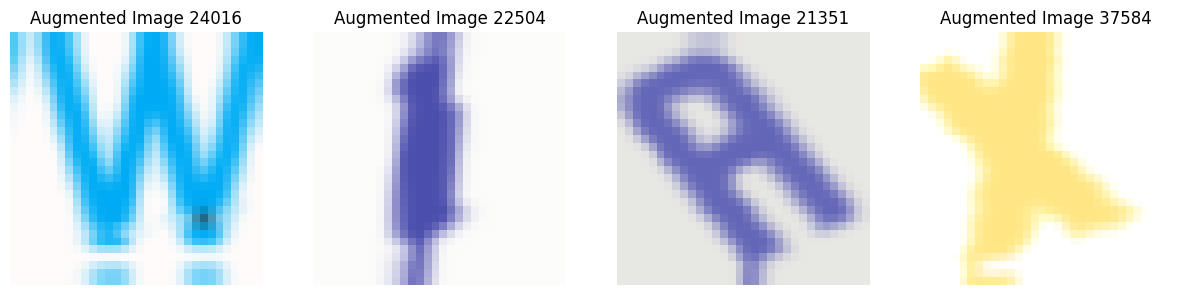

In [33]:
# Save images
output_folder = "./data/augmented_chars"
df_augment['augmented_names'] = df_augment['file_names'].apply(lambda x: x.replace('_char_', '_aug_'))
display_random_images(df_augment, 4)

for index, row in df_augment.iterrows():
    save_path = os.path.join(output_folder, row['augmented_names'])
    # Convert the image back to the range [0, 255]
    augmented_image = (row['augmented_chars'] * 255).astype(np.uint8)
    cv2.imwrite(save_path, augmented_image)

# 5. Cleaned Data Collection For Training


len(X):  41147
len(y):  41147
Sample image:


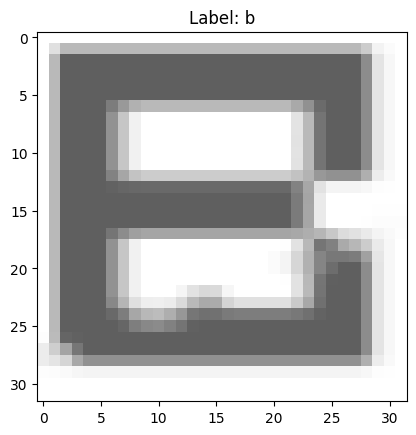

In [34]:
X = []
Y = []

folder_path = "./data/extracted_chars"
aug_folder_path = "./data/augmented_chars"
file_list = os.listdir(folder_path)
aug_file_list = os.listdir(aug_folder_path)
df = pd.DataFrame(file_list, columns=["file_name"])
df_augment = pd.DataFrame(aug_file_list, columns=["file_name"])
df["original_file_path"] = df["file_name"].apply(lambda x: os.path.join(folder_path, x))
df_augment["original_file_path"] = df_augment["file_name"].apply(lambda x: os.path.join(aug_folder_path, x))
df["label"] = df["file_name"].apply(lambda x: x.split("-0")[-1].split(".png")[0])
df_augment["label"] = df_augment["file_name"].apply(lambda x: x.split("-0")[-1].split(".png")[0])

df = pd.concat([df, df_augment])

for filename in os.listdir(folder_path):
    re_match = re.search(r"(\d+)(?=\.png)", filename)
    if not re_match:
        print(f"Could not read {filename}, skipping")
        continue

    digit = int(re_match.group(1))
    if digit != 0 or not is_colab_used:
        file_path = os.path.join(folder_path, filename)
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

        if image is not None:
            # Resize the image to 32x32 pixels
            resized_image = cv2.resize(image, (32, 32))
            X.append(resized_image)
            Y.append(filename[digit - 1])
        else:
            print(f"Could not read {filename} from {file_path}, skipping")

print("len(X): ", len(X))
print("len(y): ", len(Y))
print("Sample image:")
rand_idx = np.random.randint(0, len(X))
plt.imshow(cv2.cvtColor(X[rand_idx], cv2.COLOR_BGR2RGB))
plt.title(f"Label: {Y[rand_idx]}")

X = np.array(X)
Y = np.array(Y)

# 6. Preparing Processed Data for Training

In [35]:
digits = [str(i) for i in range(10)]
letters = [chr(i) for i in range(ord("a"), ord("z") + 1)]
char_list = digits + letters


# Normalize
def normalize_data(data):
    return data / 255.0


# One hot encoding
def one_hot_encode_labels(labels):
    label_encoder = LabelEncoder()
    label_encoder.fit(char_list)

    encoded = label_encoder.transform(labels)
    categorical = to_categorical(encoded, num_classes=len(char_list))

    return categorical


X = normalize_data(X)
Y = one_hot_encode_labels(Y)

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

# 7. Building Model


In [36]:
# Build Model Function
def build_model(learning_rate=0.01, dropout_rate=0.5):
    model = models.Sequential()
    model.add(
        layers.Conv2D(
            filters=32, kernel_size=(3, 3), activation="relu", input_shape=(32, 32, 1)
        )
    )
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(36, activation="softmax"))  # 0-9, a-z

    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model


# Train Model Function
def train_model(X, y):
    label_encoder = LabelEncoder()
    label_encoder.fit(char_list)

    y_encoded = label_encoder.transform(y)
    y_categorical = to_categorical(y_encoded, num_classes=36)

    model = build_model(input_shape=X.shape[1:])  # Using input shape from X
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    model.fit(X, y_categorical, epochs=10, batch_size=32)

    return model, label_encoder


# Predict Function
def predict_model(model, label_encoder, X):
    predictions = model.predict(X)
    predicted_classes = np.argmax(predictions, axis=1)
    predicted_labels = label_encoder.inverse_transform(predicted_classes)
    return predicted_labels

# 8. Cross Validation


In [37]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_accuracy = []

for train_idx, val_idx in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    model = build_model()

    model.fit(
        X_train_fold,
        y_train_fold,
        epochs=10,
        validation_data=(X_val_fold, y_val_fold),
        batch_size=64,
    )

    val_loss, val_acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    kf_accuracy.append(val_acc)

print(f"Cross-Validation Accuracies: {kf_accuracy}")
print(f"Mean Accuracy: {np.mean(kf_accuracy)}")

Epoch 1/10


/Users/vishnusundaresan/Documents/School/CS4243/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0394 - loss: 3.7374 - val_accuracy: 0.0257 - val_loss: 3.5864
Epoch 2/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0286 - loss: 3.5854 - val_accuracy: 0.0307 - val_loss: 3.5846
Epoch 3/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0272 - loss: 3.5851 - val_accuracy: 0.0311 - val_loss: 3.5844
Epoch 4/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0282 - loss: 3.5851 - val_accuracy: 0.0237 - val_loss: 3.5866
Epoch 5/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0270 - loss: 3.5854 - val_accuracy: 0.0299 - val_loss: 3.5844
Epoch 6/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0293 - loss: 3.5852 - val_accuracy: 0.0273 - val_loss: 3.5849
Epoch 7/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0272 - loss: 3.5847 - val_accuracy: 0.0311 - val_loss: 3.5833
Epoch 8/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0291 - loss: 3.5849 - val_accuracy: 0.0237 - val_

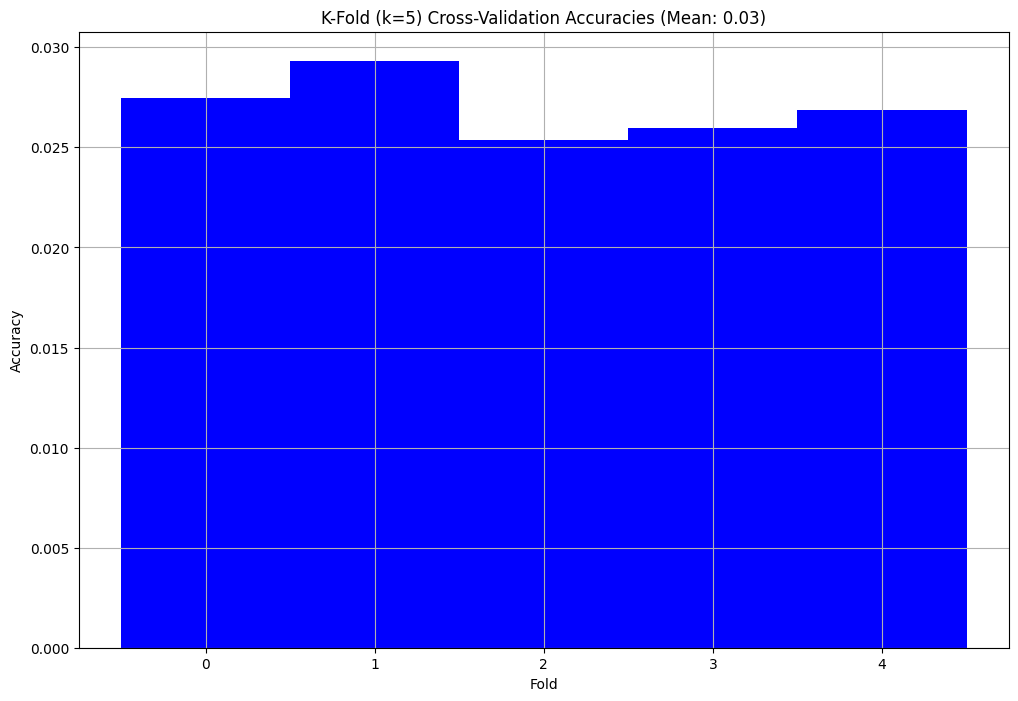

In [38]:
# Plot K-Fold Cross-Validation Accuracies
plt.figure(figsize=(12, 8))
plt.bar(range(len(kf_accuracy)), kf_accuracy, color=(0, 0, 1), width=1.0)

# Configure plot
plt.title(
    f"K-Fold (k=5) Cross-Validation Accuracies (Mean: {np.mean(kf_accuracy):.2f})"
)
plt.xlabel("Fold")
plt.ylabel("Accuracy")
# plt.xticks([])  # Remove x-axis ticks to focus on color distribution
plt.grid()

# Show the plot
plt.show()

# 9. Hyperparameter Tuning


In [39]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

model = KerasClassifier(build_fn=build_model, verbose=0)

# Define the grid of hyperparameters
param_grid = {
    "model__learning_rate": [0.001, 0.01, 0.1],
    "model__dropout_rate": [0.0, 0.2, 0.5],
}

# Conduct the grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

# Print the best hyperparameters
print(f"Best Hyperparameters: {grid_result.best_params_}")
optimal_learning_rate = grid_result.best_params_["model__learning_rate"]
optimal_dropout_rate = grid_result.best_params_["model__dropout_rate"]

/Users/vishnusundaresan/Documents/School/CS4243/.venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/vishnusundaresan/Documents/School/CS4243/.venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/vishnusundaresan/Documents/School/CS4243/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/vishnusundaresan/Documents/School/CS4243/.v

Best Hyperparameters: {'model__dropout_rate': 0.0, 'model__learning_rate': 0.001}


In [40]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_accuracy = []

for train_idx, val_idx in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    model = build_model(
        learning_rate=optimal_learning_rate, dropout_rate=optimal_dropout_rate
    )

    model.fit(
        X_train_fold,
        y_train_fold,
        epochs=10,
        validation_data=(X_val_fold, y_val_fold),
        batch_size=64,
    )

    val_loss, val_acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    kf_accuracy.append(val_acc)

print(f"Cross-Validation Accuracies: {kf_accuracy}")
print(f"Mean Accuracy: {np.mean(kf_accuracy)}")

Epoch 1/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4075 - loss: 2.2644 - val_accuracy: 0.3086 - val_loss: 2.5205
Epoch 2/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6945 - loss: 1.0740 - val_accuracy: 0.6063 - val_loss: 1.3841
Epoch 3/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7671 - loss: 0.7897 - val_accuracy: 0.4200 - val_loss: 3.4536
Epoch 4/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8143 - loss: 0.6183 - val_accuracy: 0.6974 - val_loss: 1.2169
Epoch 5/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8459 - loss: 0.5006 - val_accuracy: 0.6964 - val_loss: 1.3432
Epoch 6/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8697 - loss: 0.4189 - val_accuracy: 0.6537 - val_loss: 1.4426
Epoch 7/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8935 - loss: 0.3427 - val_accuracy: 0.7091 - val_loss: 1.1300
Epoch 8/10
412/412 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9127 - loss: 0.2878 - val_accuracy: 0.

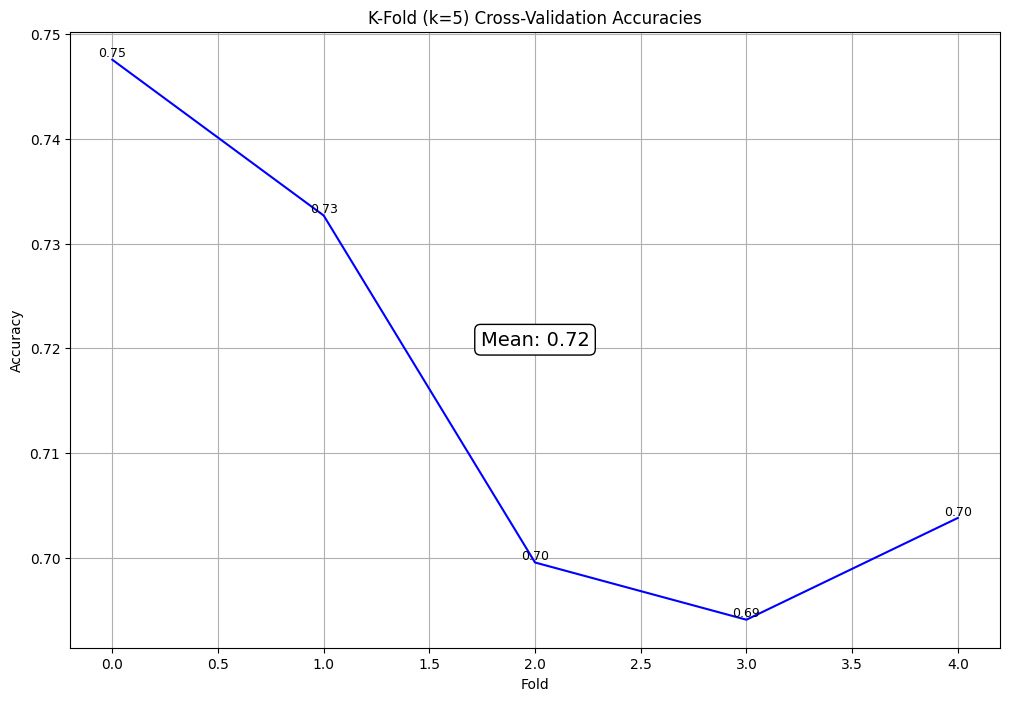

In [41]:
# Plot K-Fold Cross-Validation Accuracies
plt.figure(figsize=(12, 8))
plt.plot(range(len(kf_accuracy)), kf_accuracy, color=(0, 0, 1))
plt.annotate(
    f"Mean: {np.mean(kf_accuracy):.2f}",
    xy=(0.5, 0.5),
    xycoords="axes fraction",
    ha="center",
    va="center",
    fontsize=14,
    bbox=dict(boxstyle="round", fc="w", ec="k"),
)
for a in range(len(kf_accuracy)):
    plt.text(
        a,
        kf_accuracy[a],
        f"{kf_accuracy[a]:.2f}",
        ha="center",
        va="bottom",
        fontsize=9,
        color="black",
    )

# Configure plot
plt.title(
    f"K-Fold (k=5) Cross-Validation Accuracies"
)
plt.xlabel("Fold")
plt.ylabel("Accuracy")
# plt.xticks([])  # Remove x-axis ticks to focus on color distribution
plt.grid()

# Show the plot
plt.show()

# 10. Build and Save the Model

In [42]:
# Save the model
from datetime import datetime
from zoneinfo import ZoneInfo

model = build_model(
    learning_rate=optimal_learning_rate, dropout_rate=optimal_dropout_rate
)

# Graph training
log_dir = "logs/fit/" + datetime.now(tz=ZoneInfo("UTC")).strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(  # type: ignore
    log_dir=log_dir, histogram_freq=1
)


model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=64,
    callbacks=[tensorboard_callback],
)


model_name = f"model-{datetime.now(tz=ZoneInfo('UTC'))}.keras"
model.save(model_name)
model.save("latest.keras")

Epoch 1/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4266 - loss: 2.1356
Epoch 2/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7391 - loss: 0.9091
Epoch 3/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8048 - loss: 0.6525
Epoch 4/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8376 - loss: 0.5239
Epoch 5/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8639 - loss: 0.4369
Epoch 6/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8874 - loss: 0.3545
Epoch 7/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8956 - loss: 0.3103
Epoch 8/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9076 - loss: 0.2803
Epoch 9/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9179 - loss: 0.2542
Epoch 10/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9229 - loss: 0.2291
Epoch 11/100
515/515 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9351 - loss: 0.1957
Epoch 12/100
515/515 ━━━━━━━━━━━━━━━━━━━━

In [43]:
# # Visualize Tensorboard
# %load_ext tensorboard
# %tensorboard --logdir {tensorboard_callbacak.log_dir}

# 11. Testing the Model

258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
{'0': {'precision': 0.5752212389380531, 'recall': 0.5701754385964912, 'f1-score': 0.5726872246696035, 'support': 228.0}, '1': {'precision': 0.7243589743589743, 'recall': 0.4808510638297872, 'f1-score': 0.578005115089514, 'support': 235.0}, '2': {'precision': 0.7324561403508771, 'recall': 0.8564102564102564, 'f1-score': 0.789598108747045, 'support': 195.0}, '3': {'precision': 0.8793103448275862, 'recall': 0.8535564853556485, 'f1-score': 0.8662420382165605, 'support': 239.0}, '4': {'precision': 0.8095238095238095, 'recall': 0.8292682926829268, 'f1-score': 0.8192771084337349, 'support': 246.0}, '5': {'precision': 0.8271028037383178, 'recall': 0.8119266055045872, 'f1-score': 0.8194444444444444, 'support': 218.0}, '6': {'precision': 0.8407079646017699, 'recall': 0.8016877637130801, 'f1-score': 0.8207343412526998, 'support': 237.0}, '7': {'precision': 0.7413127413127413, 'recall': 0.8847926267281107, 'f1-score': 0.8067226890756303, 'support': 217.0}, 

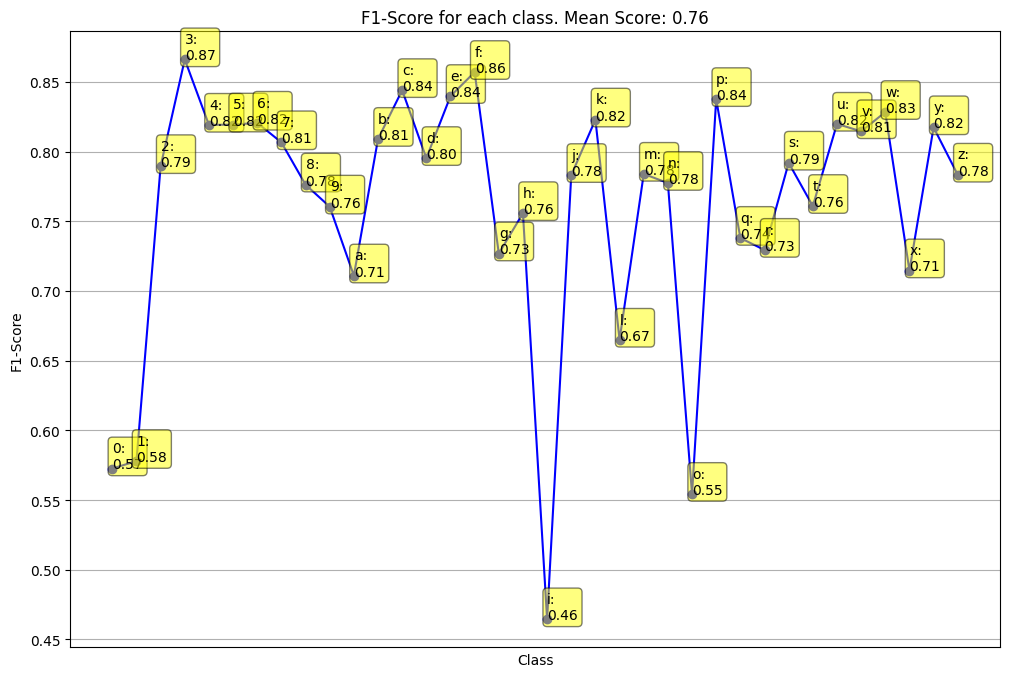

Test Accuracy: 0.7637910085054678
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.57      0.57       228
           1       0.72      0.48      0.58       235
           2       0.73      0.86      0.79       195
           3       0.88      0.85      0.87       239
           4       0.81      0.83      0.82       246
           5       0.83      0.81      0.82       218
           6       0.84      0.80      0.82       237
           7       0.74      0.88      0.81       217
           8       0.71      0.85      0.78       216
           9       0.78      0.74      0.76       254
           a       0.73      0.70      0.71       207
           b       0.86      0.76      0.81       255
           c       0.86      0.83      0.84       236
           d       0.89      0.72      0.80       241
           e       0.84      0.84      0.84       215
           f       0.88      0.84      0.86       244
           g       0.70 

In [45]:
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras import models


digits = [str(i) for i in range(10)]
letters = [chr(i) for i in range(ord("a"), ord("z") + 1)]
char_list = digits + letters

loaded_model = models.load_model("model-2024-11-16 01:41:45.238531+00:00.keras")
y_pred = loaded_model.predict(X_test)


def decode_predictions(preds):
    label_encoder = LabelEncoder()
    label_encoder.fit(char_list)
    decoded_labels = label_encoder.inverse_transform(preds.argmax(axis=1))
    return decoded_labels


y_pred_decoded = decode_predictions(y_pred)
y_test_decoded = decode_predictions(y_test)

accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
num_report = classification_report(y_test_decoded, y_pred_decoded, output_dict=True)

assert type(num_report) == dict

print(num_report)
f1_scores = [num_report[label]["f1-score"] for label in char_list]
# Plot Graph using num_report
plt.figure(figsize=(12, 8))
plt.plot(char_list, f1_scores, marker="o", color="b", label="F1-Score")
# Plot each dot with class name label
for i, txt in enumerate(char_list):
    plt.annotate(
        f"{txt}:\n{f1_scores[i]:.2f}",
        (i, f1_scores[i]),
        bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="black", lw=1, alpha=0.5),
    )
plt.title(f"F1-Score for each class. Mean Score: {accuracy:.2f}")
plt.xlabel("Class")
plt.ylabel("F1-Score")
plt.xticks([])
plt.grid()
plt.show()

report = classification_report(y_test_decoded, y_pred_decoded, output_dict=False)

print(f"Test Accuracy: {accuracy}")
print("Classification Report:")
print(report)